testing deepIRES on our dataset

In [1]:
import numpy as np
import pandas as pd
from model.model import deepires_model
from model.sequence_encode import get_data_onehot
from Bio import SeqIO
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score,accuracy_score,recall_score,matthews_corrcoef,confusion_matrix,roc_curve, precision_recall_curve, auc


In [2]:
# get the dataset we are teesting
active_df = pd.read_csv('./dataset/external_testing_dataset/Human_5UTR_HMM_ires_activity.csv')
print(active_df.head)
print(active_df.shape)

<bound method NDFrame.head of      Unnamed: 0  Index                                         Oligo_name  \
0            20     21  no_barcode;Human_5UTR_Screen;NDUFC1;NM_0011849...   
1            26     27  no_barcode;Human_5UTR_Screen;MAGEA8;NM_0011664...   
2            32     33  no_barcode;Human_5UTR_Screen;SSR4;NM_006280;12...   
3            38     39  no_barcode;Human_5UTR_Screen;RPL32;NM_00100707...   
4            41     42  no_barcode;Human_5UTR_Screen;B4GALT3;NM_003779...   
..          ...    ...                                                ...   
654       29680  29681  8nt_barcode;Human_5UTR_Screen;AGTRAP;NM_001040...   
655       29709  29710  8nt_barcode;Human_5UTR_Screen;CHI3L2;NM_001025...   
656       29716  29717  8nt_barcode;Human_5UTR_Screen;ZNF250;NM_021061...   
657       29943  29944  8nt_barcode;Human_5UTR_Screen;TMCO1;NM_0012561...   
658       29974  29975  8nt_barcode;Human_5UTR_Screen;ANXA2;NM_0010028...   

                                             

In [3]:
y_test = np.where(active_df['ires_activity'] >= 600, 1, 0)
print(y_test.shape)
print(y_test)

(659,)
[1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1

In [4]:
# DeepIRES script code
def read_fa(path):
    res = {}
    records = list(SeqIO.parse(path, format='fasta'))
    for x in records:
        id = str(x.id)
        seq = str(x.seq)
        res[id] = seq
    return res

def predict_score(data):
    test = []
    start = []
    stop = []
    model = deepires_model()
    model.load_weights('weights/first').expect_partial()
    for seq in data:
        if (len(seq)) > 174:
            score = []
            i = 1
            while i + 173 <= len(seq):
                seqq = np.array(seq[i - 1:i + 173]).reshape(1, )
                x = get_data_onehot(seqq, maxlen=174)
                score.append(model.predict(x,verbose=0)[0][0])
                i = i + 50
            seqlast = np.array(seq[-174:]).reshape(1, )
            x1 = get_data_onehot(seqlast, maxlen=174)
            score.append(model.predict(x1,verbose=0)[0][0])
            max_score = max(score)
            max_index = score.index(max_score)
            test.append(max_score)
            if max_score == score[-1]:
                start.append(len(seq) - 173)
                stop.append(len(seq))
            else:
                startt = 50 * max_index + 1
                start.append(startt)
                stop.append(startt + 173)
        else:
            seqq = np.array(seq).reshape(1, )
            x = get_data_onehot(seqq, maxlen=174)
            test.append(model.predict(x,verbose=0)[0][0])
            start.append(1)
            stop.append(len(seq))
    return test, start, stop

In [5]:
# preprocess sequences then save them to np array
train_data = np.load('./dataset/train/train_set.npz')

In [6]:
for key in train_data:
    print(key)

X_tra
y_tra


In [65]:
print(train_data["X_tra"][:2])
print(train_data["X_tra"].shape)

[[1 3 1 2 3 1 3 3 1 1 4 4 3 3 1 1 4 1 2 3 3 3 4 3 3 1 1 3 1 1 1 4 3 3 3 3
  3 1 1 1 1 2 1 4 4 3 4 4 4 3 4 2 1 2 4 2 2 1 2 2 2 1 4 3 4 2 2 1 1 4 1 1
  2 1 2 1 4 4 4 3 4 4 3 4 3 3 1 4 3 3 4 2 2 2 1 1 1 1 2 1 1 1 1 3 1 1 4 3
  2 2 2 1 3 1 4 3 1 3 1 1 4 1 3 1 3 2 2 4 3 3 1 1 2 1 3 4 4 4 1 3 1 1 3 4
  3 3 1 3 3 1 4 4 4 4 3 3 1 4 4 4 3 3 3 2 4 1 1 2 1 4 2 1 1 2]
 [4 3 3 4 3 2 4 1 3 1 1 3 3 1 3 1 4 1 3 2 4 3 2 4 4 3 1 2 1 1 4 2 1 4 3 3
  2 1 1 1 2 3 1 2 1 1 1 2 2 1 1 2 1 4 4 3 3 1 2 3 4 2 2 3 2 1 4 3 1 4 4 1
  1 2 1 4 2 3 1 1 3 2 4 1 3 2 2 1 1 2 4 4 3 2 4 3 1 3 3 4 2 1 3 1 1 3 4 4
  1 2 4 3 2 4 1 4 2 1 4 3 2 4 4 2 1 3 4 2 1 2 4 3 1 2 1 4 2 4 2 3 1 2 3 3
  4 3 3 2 4 2 3 3 4 3 2 2 2 2 1 2 3 1 2 4 3 3 1 3 1 1 3 2 4 2]]
(16674, 174)


In [25]:
test_seq = active_df['Sequence'][0]
print(test_seq)
print(np.array(test_seq).shape)
print(np.array(test_seq).reshape(1, ))
print(get_data_onehot(np.array(test_seq).reshape(1, ), 174))

CTAGGGCGCGCCAGTCCTGACTACAAGGAGACAGAAGGCTGAGGCCGGGGTGCTAGAGAACCTTGCCGTGCTGGAATTCACGTTGACGCCCCCACGGAGCTCTGCTGCAGAGCCCTCGAGTCCCGCACTTCCGGCCGCCAGGTGGCGCTGGTTCTGTTGCCAACTCGGAGAGACTGAGCTGGGCCACGCAAGCGACTCGGACCGATGGTGAG
()
['CTAGGGCGCGCCAGTCCTGACTACAAGGAGACAGAAGGCTGAGGCCGGGGTGCTAGAGAACCTTGCCGTGCTGGAATTCACGTTGACGCCCCCACGGAGCTCTGCTGCAGAGCCCTCGAGTCCCGCACTTCCGGCCGCCAGGTGGCGCTGGTTCTGTTGCCAACTCGGAGAGACTGAGCTGGGCCACGCAAGCGACTCGGACCGATGGTGAG']
[[2 4 3 1 3 3 2 2 3 3 3 3 4 3 2 4 1 3 1 3 1 1 2 2 4 4 3 2 2 3 4 3 2 4 3 3
  1 1 4 4 2 1 2 3 4 4 3 1 2 3 2 2 2 2 2 1 2 3 3 1 3 2 4 2 4 3 2 4 3 2 1 3
  1 3 2 2 2 4 2 3 1 3 4 2 2 2 3 2 1 2 4 4 2 2 3 3 2 2 3 2 2 1 3 3 4 3 3 2
  3 2 4 3 3 4 4 2 4 3 4 4 3 2 2 1 1 2 4 2 3 3 1 3 1 3 1 2 4 3 1 3 2 4 3 3
  3 2 2 1 2 3 2 1 1 3 2 3 1 2 4 2 3 3 1 2 2 3 1 4 3 3 4 3 1 3]]


In [64]:
test_ndarray = np.array(active_df['Sequence'])
print(test_ndarray.shape)
print(test_ndarray.reshape(659, 1)[0])
updated_ndarray = test_ndarray.reshape(659,1)
onehot_data = get_data_onehot(updated_ndarray[0], 174)
print(onehot_data.shape)
print(onehot_data[0])


(659,)
['CTAGGGCGCGCCAGTCCTGACTACAAGGAGACAGAAGGCTGAGGCCGGGGTGCTAGAGAACCTTGCCGTGCTGGAATTCACGTTGACGCCCCCACGGAGCTCTGCTGCAGAGCCCTCGAGTCCCGCACTTCCGGCCGCCAGGTGGCGCTGGTTCTGTTGCCAACTCGGAGAGACTGAGCTGGGCCACGCAAGCGACTCGGACCGATGGTGAG']
(1, 174)
[2 4 3 1 3 3 2 2 3 3 3 3 4 3 2 4 1 3 1 3 1 1 2 2 4 4 3 2 2 3 4 3 2 4 3 3 1
 1 4 4 2 1 2 3 4 4 3 1 2 3 2 2 2 2 2 1 2 3 3 1 3 2 4 2 4 3 2 4 3 2 1 3 1 3
 2 2 2 4 2 3 1 3 4 2 2 2 3 2 1 2 4 4 2 2 3 3 2 2 3 2 2 1 3 3 4 3 3 2 3 2 4
 3 3 4 4 2 4 3 4 4 3 2 2 1 1 2 4 2 3 3 1 3 1 3 1 2 4 3 1 3 2 4 3 3 3 2 2 1
 2 3 2 1 1 3 2 3 1 2 4 2 3 3 1 2 2 3 1 4 3 3 4 3 1 3]


In [ ]:
results = []

for reshaped_arr in updated_ndarray:
    onehot = get_data_onehot(reshaped_arr, 174)
    results.append(onehot[0])

result_ndarray = np.array(results)
print(result_ndarray.shape)
print(result_ndarray[0])

[2 4 3 1 3 3 2 2 3 3 3 3 4 3 2 4 1 3 1 3 1 1 2 2 4 4 3 2 2 3 4 3 2 4 3 3 1
 1 4 4 2 1 2 3 4 4 3 1 2 3 2 2 2 2 2 1 2 3 3 1 3 2 4 2 4 3 2 4 3 2 1 3 1 3
 2 2 2 4 2 3 1 3 4 2 2 2 3 2 1 2 4 4 2 2 3 3 2 2 3 2 2 1 3 3 4 3 3 2 3 2 4
 3 3 4 4 2 4 3 4 4 3 2 2 1 1 2 4 2 3 3 1 3 1 3 1 2 4 3 1 3 2 4 3 3 3 2 2 1
 2 3 2 1 1 3 2 3 1 2 4 2 3 3 1 2 2 3 1 4 3 3 4 3 1 3]
(659, 174)
[2 4 3 1 3 3 2 2 3 3 3 3 4 3 2 4 1 3 1 3 1 1 2 2 4 4 3 2 2 3 4 3 2 4 3 3 1
 1 4 4 2 1 2 3 4 4 3 1 2 3 2 2 2 2 2 1 2 3 3 1 3 2 4 2 4 3 2 4 3 2 1 3 1 3
 2 2 2 4 2 3 1 3 4 2 2 2 3 2 1 2 4 4 2 2 3 3 2 2 3 2 2 1 3 3 4 3 3 2 3 2 4
 3 3 4 4 2 4 3 4 4 3 2 2 1 1 2 4 2 3 3 1 3 1 3 1 2 4 3 1 3 2 4 3 3 3 2 2 1
 2 3 2 1 1 3 2 3 1 2 4 2 3 3 1 2 2 3 1 4 3 3 4 3 1 3]


In [68]:
# save the training set into a npz file
filename = "./dataset/external_testing_dataset/ires_activity.npz"
np.savez(filename, X=result_ndarray, y=y_test)

In [69]:
# test that the data matches up
ires_activity_from_npz = np.load("./dataset/external_testing_dataset/ires_activity.npz")
for key in ires_activity_from_npz:
    print(key)
    print(ires_activity_from_npz[key].shape)

X
(659, 174)
y
(659,)


Testing DeepIRES performance on our IRES dataset using their pretrained weights

In [5]:
sequences = active_df['Sequence'].tolist()

In [6]:
score, start, stop = predict_score(sequences)

In [7]:
print(score)
print(type(score))

[0.23400979, 0.92866194, 0.9907765, 0.4196611, 0.6290846, 0.91535705, 0.056642294, 0.10404917, 0.09062015, 0.7255848, 0.73405385, 0.27005407, 0.42994255, 0.42719737, 0.67927694, 0.97456944, 0.36581135, 0.79927844, 0.6607211, 0.36848372, 0.96207774, 0.60490525, 0.68157715, 0.44340193, 0.39013246, 0.45051497, 0.2492027, 0.3801907, 0.97129613, 0.3029753, 0.9586837, 0.93696815, 0.2590931, 0.84421384, 0.40574, 0.9547239, 0.9621006, 0.43408298, 0.97613436, 0.8887957, 0.4403592, 0.30287257, 0.36931804, 0.41538072, 0.3850438, 0.2538266, 0.9637609, 0.37469167, 0.09210321, 0.329754, 0.6671131, 0.99709356, 0.14237624, 0.73971254, 0.92578083, 0.9645497, 0.8995396, 0.6338769, 0.85344535, 0.26762566, 0.90147793, 0.620972, 0.18228759, 0.1908916, 0.98174477, 0.9986732, 0.3557818, 0.22752887, 0.9721078, 0.68060267, 0.6851126, 0.9725364, 0.48483145, 0.22718894, 0.24303286, 0.437754, 0.992709, 0.16045037, 0.6214963, 0.12900151, 0.4277993, 0.4391513, 0.43908057, 0.63129616, 0.2229377, 0.9511895, 0.9557957

In [8]:
y_pred_score = np.array(score)
y_pred=np.where(y_pred_score>0.5,1,0)

In [9]:
print(y_pred)

[0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1
 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1
 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0
 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1
 0 1 0 1 0 1 1 0 1 1 1 1 

In [10]:
# evaluation on our data...
acc = accuracy_score(y_test, y_pred)
sn = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
sp = tn / (tn + fp)
auroc = roc_auc_score(y_test, y_pred_score)
f1 = f1_score(y_test, y_pred.reshape(-1))
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_score)
aupr=auc(lr_recall,lr_precision)

print("ACC : ", acc)
print("SN : ", sn)
print("SP : ", sp)
print("MCC : ", mcc)
print("AUC : ", auroc)
print("F1-sorce : ", f1)
print("AUPR : ", aupr)

ACC :  0.5462822458270106
SN :  0.5472727272727272
SP :  0.5412844036697247
MCC :  0.0659461149310158
AUC :  0.5935779816513762
F1-sorce :  0.6681465038845728
AUPR :  0.8934299577002078


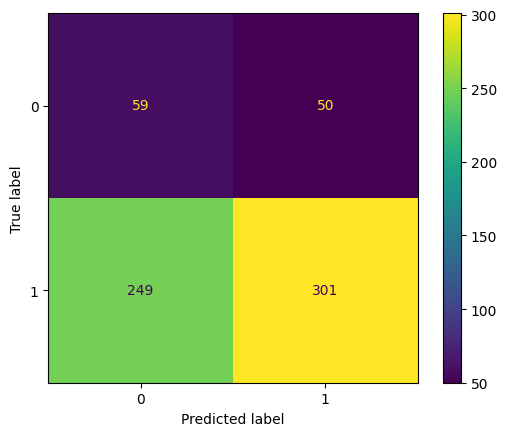

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.show()